<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# **BLIP-2 : Bridging Vision and Language with Frozen Models**


In the world of vision-language models, training large-scale models end-to-end has been the traditional approach to achieve state-of-the-art performance. But as models grow larger and datasets expand, the computational cost of training these models from scratch becomes increasingly prohibitive. 

**What if, instead of training everything from the ground up, we could harness the power of *pre-trained giants*—state-of-the-art vision encoders and large language models (LLMs)—and simply bridge the gap between them?**

<img src="../images/blip-2-model.jpg" alt="blip-2 architecture" width="800"/>

Enter **BLIP-2**, a revolutionary framework introduced in 2023. Instead of training massive models end-to-end, BLIP-2 leverages **frozen pre-trained image encoders** (like CLIP or EVA-CLIP) and **frozen LLMs** (such as OPT or FlanT5), and introduces a lightweight **Querying Transformer (Q-Former)** to align these two modalities. This approach not only reduces the number of trainable parameters but also achieves superior performance on tasks like **visual question answering**, **image captioning**, and **zero-shot image-to-text generation**.




| **Aspect**               | **BLIP**                                                                 | **BLIP-2**                                                                 |
|--------------------------|-------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **Model Architecture**   | Uses end-to-end training with both image and text encoders trainable.   | Freezes pre-trained image encoders and LLMs, introduces lightweight Q-Former. |
| **Training Efficiency**  | Requires full training of vision and language components.               | More efficient; only Q-Former is trained, reducing trainable parameters.   |
| **Zero-shot Capabilities** | Limited zero-shot capabilities compared to BLIP-2.                     | Strong zero-shot performance, especially in image-to-text generation.      |
| **Performance**          | Achieves strong results but requires more computational resources.      | Outperforms BLIP and other models with fewer trainable parameters.         |
| **Emergent Capabilities** | Focuses on vision-language understanding and generation.                | Adds advanced zero-shot capabilities like visual reasoning and storytelling.|
| **Pre-training Strategy**| Single-stage pre-training with image-text pairs.                        | Two-stage pre-training: representation learning followed by generative learning. |


## **Query Transformer (Q-Former) Architecture**

The **Query Transformer (Q-Former)** is the cornerstone of BLIP-2, serving as the bridge between frozen pre-trained image encoders and large language models (LLMs). The primary role of the Q-Former is to extract **visual features** from a frozen image encoder and translate them into a format that a frozen LLM can understand. By acting as an **information bottleneck**, the Q-Former ensures that only the most relevant visual information is passed to the LLM, enabling effective vision-language alignment while minimizing unnecessary computation.

### **Model Architecture**

<img src="../images/blip-2.png" alt="blip-2 architecture" width="700"/>

The Q-Former consists of two main components:
1. **Image Transformer (Left)**: Interacts with the frozen image encoder to extract visual features. It uses **learnable query embeddings** to interact with the image features through cross-attention layers.
2. **Text Transformer (Right)**: Functions as both a text encoder and decoder, allowing the model to process and generate text. It shares self-attention layers with the Image Transformer, enabling seamless interaction between visual and textual information.

#### **Features of the Q-Former**

 - **Learnable Query Embeddings**: The Q-Former uses a fixed number of **learnable query embeddings** as input to the Image Transformer. These queries interact with each other through self-attention and with the frozen image features through cross-attention layers. This design ensures that the queries extract the most relevant visual information for downstream tasks.

 - **Self-Attention and Cross-Attention Mechanisms**
    - **Self-Attention**: Allows queries to interact with each other and with text tokens, depending on the task. Different attention masks are applied to control the flow of information between queries and text.
    - **Cross-Attention**: Enables the queries to interact with the frozen image features, extracting visual information that is most relevant to the text.

 - **Information Bottleneck**: The Q-Former’s architecture forces it to extract only the most **language-relevant visual features**, effectively acting as an information bottleneck. This reduces the burden on the LLM to learn vision-language alignment from scratch, mitigating issues like **catastrophic forgetting** and improving overall efficiency.

 - **Parameter Efficiency and Lightweight Design**: With only **188 million parameters**, the Q-Former is significantly smaller than the frozen models it bridges. Its lightweight design makes BLIP-2 highly **parameter-efficient**, allowing it to achieve state-of-the-art performance while requiring far fewer trainable parameters compared to end-to-end models.


## **Training Step 1: Vision-Language Representation Learning**

The first stage of BLIP-2’s training focuses on **vision-language representation learning**, where the Q-Former learns to extract visual features that are most relevant to the accompanying text. This stage connects the Q-Former to a **frozen image encoder** and jointly optimizes three pre-training objectives. Each objective uses a different attention masking strategy to control the interaction between the queries and text tokens, ensuring that the Q-Former learns to align visual and textual information effectively.

### **1. Image-Text Contrastive Learning (ITC)**
- **Objective**: Maximize the mutual information between image and text representations by contrasting positive and negative image-text pairs.
- **Masking**: A **unimodal self-attention mask** is applied, preventing queries and text tokens from attending to each other. This ensures no information leakage between modalities.
- **Loss**: The model computes the similarity between the output query embeddings (from the Image Transformer) and the text representation (from the Text Transformer). The highest similarity score is used as the image-text similarity, and the loss encourages positive pairs to have higher similarity than negative pairs.
- **Reason**: ITC ensures that the Q-Former learns to align visual features with their corresponding textual descriptions.

### **2. Image-Grounded Text Generation (ITG)**
- **Objective**: Train the Q-Former to generate text conditioned on the input image.
- **Masking**: A **multimodal causal self-attention mask** is used. Queries can attend to each other but not to text tokens, while text tokens can attend to all queries and previous text tokens.
- **Loss**: The model generates text based on the visual features extracted by the queries. The loss is calculated using the standard language modeling objective, where the model predicts the next token in the sequence.
- **Reason**: ITG forces the queries to extract visual features that capture all the information needed to generate the text, improving the alignment between vision and language.

### **3. Image-Text Matching (ITM)**
- **Objective**: Learn fine-grained alignment between image and text representations by classifying whether an image-text pair is matched or unmatched.
- **Masking**: A **bidirectional self-attention mask** is applied, allowing all queries and text tokens to attend to each other.
- **Loss**: The output query embeddings are fed into a binary classifier to predict whether the image-text pair is positive or negative. The loss is calculated using cross-entropy.
- **Reason**: ITM helps the Q-Former learn to capture multimodal information, improving its ability to distinguish between relevant and irrelevant image-text pairs.

By jointly optimizing these three objectives, the Q-Former learns to extract **language-relevant visual features** from the frozen image encoder, setting the stage for the second training step: **vision-to-language generative learning**.

### **Training Step 2: Adapting Representations for LLMs**

The second stage of BLIP-2’s training focuses on **vision-to-language generative learning**, where the Q-Former adapts its visual representations to be compatible with frozen large language models (LLMs). This stage connects the Q-Former (with the frozen image encoder attached) to a frozen LLM, enabling the model to generate text conditioned on visual inputs. The goal is to fine-tune the Q-Former so that its output visual representations can be effectively interpreted by the LLM for text generation.

#### **Connection to Frozen LLM**
- The output query embeddings from the Q-Former are linearly projected into the same dimension as the LLM’s text embeddings using a **fully connected (FC) layer**.
- These projected embeddings are prepended to the input text embeddings, acting as **soft visual prompts** that condition the LLM on the visual information extracted by the Q-Former.
- By freezing the LLM, BLIP-2 leverages its powerful generative capabilities without requiring additional training of the LLM’s parameters.

#### **Pre-training with Language Modeling Loss**
- **Objective**: Train the Q-Former to generate text conditioned on the visual representation extracted from the frozen image encoder.
- **Loss**: The model uses a **language modeling loss** (for decoder-based LLMs) or a **prefix language modeling loss** (for encoder-decoder-based LLMs).
  - For **decoder-based LLMs** (e.g., OPT), the LLM generates text conditioned on the visual representation from the Q-Former.
  - For **encoder-decoder-based LLMs** (e.g., FlanT5), the text is split into a prefix and a suffix. The prefix is concatenated with the visual representation and fed into the LLM’s encoder, while the suffix is used as the generation target for the LLM’s decoder.
- **Reason**: This stage ensures that the Q-Former’s output visual representations are interpretable by the LLM, enabling the model to perform tasks like **zero-shot image-to-text generation** and **visual question answering**.

## **Use Cases**

Note: The datasets used in this notebook is available on the course portal. A teaching assisstant will help you download and set it up in your config file during the lab session.

### **Image Captioning**

In [2]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig
import torch

# Load the processor for BLIP-2
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps") if torch.backends.mps.is_available() else device

if torch.cuda.is_available():
    device = torch.device("cuda")
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    torch_dtype = torch.float16
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    quantization_config = None  # MPS doesn't support 8-bit quantization
    torch_dtype = torch.float32  # MPS works better with float32
else:
    device = torch.device("cpu")
    quantization_config = None
    torch_dtype = torch.float32

# Configure the model based on device
model_kwargs = {
    "torch_dtype": torch_dtype
}
        
if quantization_config is not None:
    model_kwargs["quantization_config"] = quantization_config
    
# Configure the model with bitsandbytes based on device
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", 
    **model_kwargs
).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

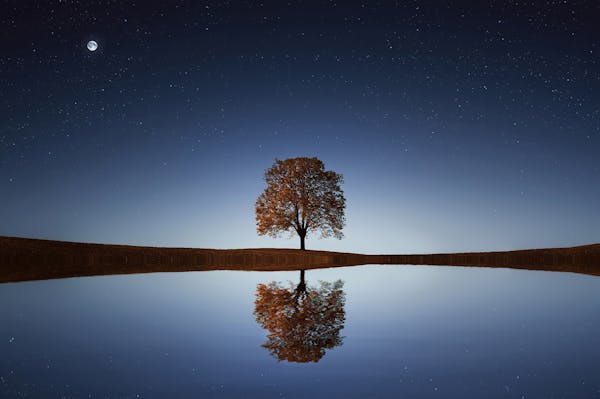

In [3]:
from svlearn_vlu import config
from PIL import Image


image_path = f"{config['datasets']['trees']}/pexels-photo-268533_1.jpeg"

image = Image.open(fp=image_path)

image

In [4]:
inputs = processor(images=image, return_tensors="pt")
# Move inputs to the correct device
inputs = {k: v.to(device) for k, v in inputs.items()}
outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: a lone tree is reflected in the water at night



In [5]:
text = "A picture of"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: A picture of a tree reflected in water



In [6]:
text = "A lone tree"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", decoded_output)

Generated Caption: A lone tree is reflected in a pond at night



### **Visual Question Answering**

In [7]:
text = "Question: What is the subject of the picture? Answer:"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print(decoded_output)

Question: What is the subject of the picture? Answer: The tree



In [8]:
text = "Question: What feeling does this image convey? Answer:"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print(decoded_output)

Question: What feeling does this image convey? Answer: The feeling of loneliness and isolation



In [9]:
text = "Question: What should a child be careful of here? Answer:"

inputs = processor(images=image, text=text, return_tensors="pt").to(device)

outputs = model.generate(**inputs)

outputs
# Decode the generated caption
decoded_output = processor.decode(outputs[0], skip_special_tokens=True)

print(decoded_output)

Question: What should a child be careful of here? Answer: The moon



Image,Caption
,BLIP: a photo of a squirrel sitting on a treeBLIP2: a squirrel sitting in a tree with its head up\n
,BLIP: a photo of a dog and a catBLIP2: a dog and a cat sitting on a bench\n
,BLIP: a photo of a person riding a bike through a puddleBLIP2: a man riding a bike through a muddy area\n
,BLIP: a photo of a city with a very view of the eiffiffiffiffiffiffiffiffiffiffiffBLIP2: the eiffel tower is seen from above the city of paris\n
,BLIP: a photo of two little owls in the grassBLIP2: three owls are sitting in the grass\n
,BLIP: a photo of a street with a car parked in front of a buildingBLIP2: a car driving down a street with a castle in the background\n
,BLIP: a photo of a group of fish with their mouths openBLIP2: fish with open mouths and teeth\n
,BLIP: a photo of a dog dressed up as a ghostBLIP2: a dog wearing a ghost costume\n
,BLIP: a photo of a skeleton wearing a tie and glassesBLIP2: a skeleton wearing glasses and a bow tie\n
,BLIP: a photo of a sign in the woodsBLIP2: a sign that says slow free range children\n

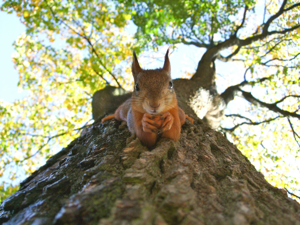
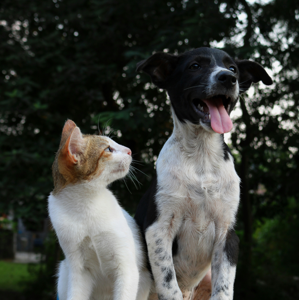
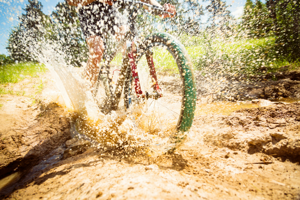
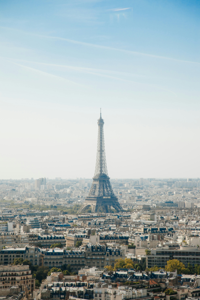
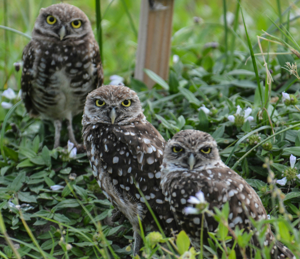
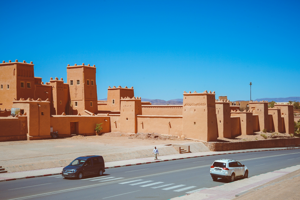
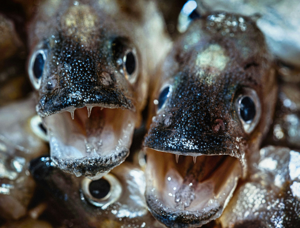
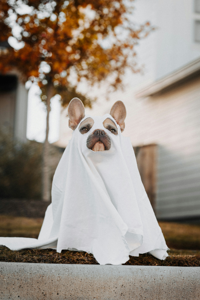
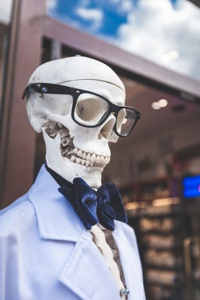
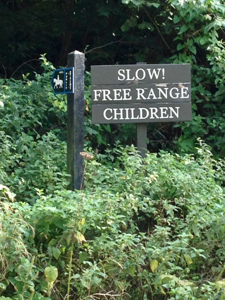
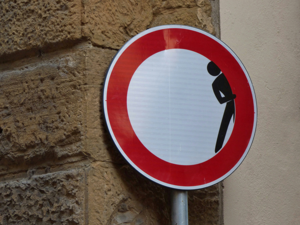
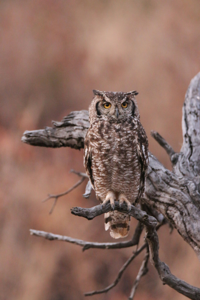
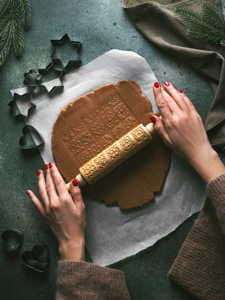
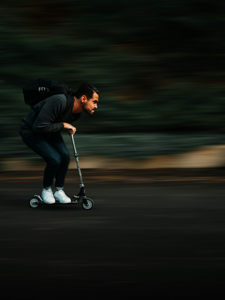
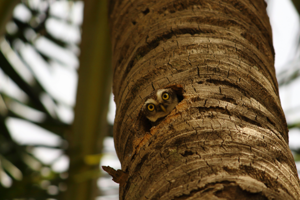
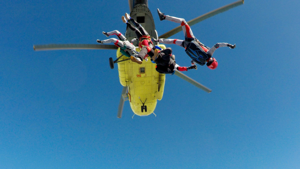
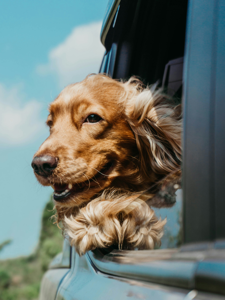
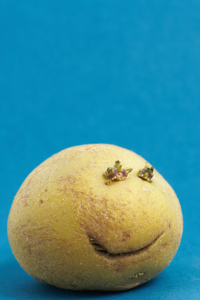
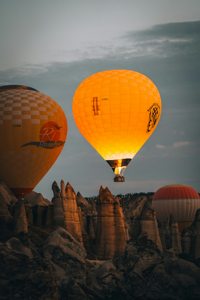
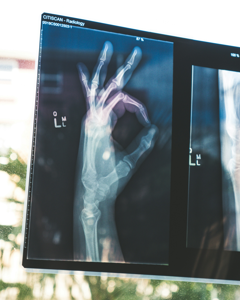
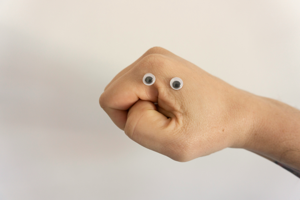
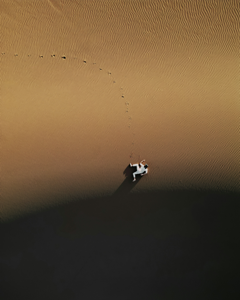
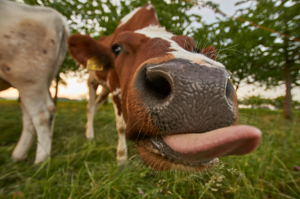
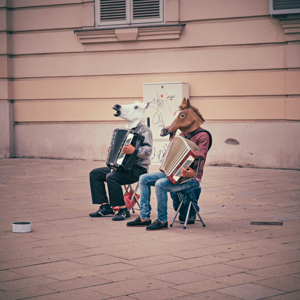
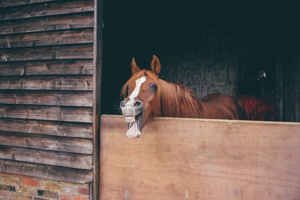

In [10]:
from svlearn_vlu.utils.display_captions_table import CaptionDisplay

image_dir = config["datasets"]["unsplash"]
captions_file = f"{image_dir}/captions.json"

caption_display = CaptionDisplay(image_dir, captions_file)
caption_display.display(num_samples=25, model_names=['blip', 'blip2'])

## Observations

<img src="../images/laura-marks-ltKH32jIqzs-unsplash.jpg" alt="blip-2 architecture" width="300"/>

**BLIP**:  
The caption, *"a photo of a sign in the woods,"* is a generic description that identifies the setting (woods) and the object (sign) but fails to capture the specific and humorous content of the sign.

**BLIP2**:  
The caption, *"a sign that says slow free range children,"* accurately describes the unique and specific text on the sign, demonstrating BLIP2's ability to recognize and interpret detailed or unconventional content.



## References

[BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models](https://arxiv.org/pdf/2301.12597)